In [1]:
import datetime as dt
import json
from collections import defaultdict
from enum import Enum

import dateutil.parser
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np


def load(path: str):
    fh = open(path)
    data = json.load(fh)
    fh.close()
    return data


data = load("../data/merged-log-SOFTENG206-2022.json")

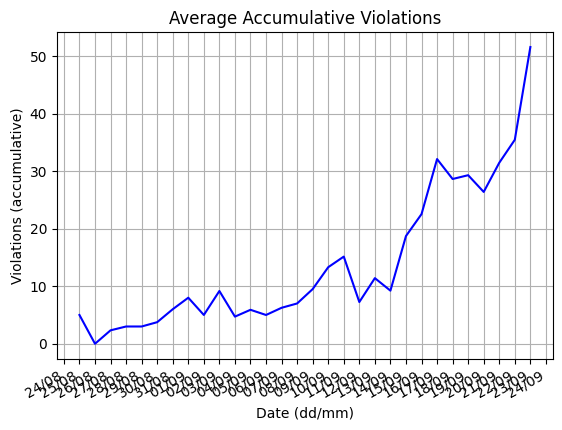

In [13]:
plt.title("Average Accumulative Violations")
plt.xlabel("Date (dd/mm)")
plt.ylabel("Violations (accumulative)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)
from statistics import mean


def date_range(start, end):
    delta = end - start
    days = [start + dt.timedelta(days=i) for i in range(delta.days + 1)]
    return days


# sliding window of average vioaltions accumulated between (day to day)
def acc2(data):
    # name => [(date, violations)]
    groups = defaultdict(list)
    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            date = dateutil.parser.isoparse(x["Time"])

        violations = x["violations"]
        # remove binary biolation as it was very broken at a point
        violations = list(
            filter(lambda x: x["Name"] not in ["BinaryViolation"], violations)
        )
        groupName = x["name"]
        groups[groupName].append((date, violations))

    # sort each of the data points by date
    for k in groups.keys():
        groups[k] = list(sorted(groups[k], key=lambda x: x[0]))

    # find min and max date
    dates = []
    for (k, ds) in groups.items():
        for (d, v) in ds:
            dates.append(d)

    maxDate = max(d for d in dates if isinstance(d, dt.date))
    minDate = min(d for d in dates if isinstance(d, dt.date))

    # round to nearest day start
    minDate = minDate.replace(hour=0, minute=0, second=0, microsecond=0)
    maxDate = maxDate.replace(hour=0, minute=0, second=0, microsecond=0)

    # range of dates monotomically increasing by day value
    dr = date_range(minDate, maxDate)

    xs = []
    ys = []
    for i in range(0, len(dr) - 2):
        lower = dr[i]
        upper = dr[i + 1]

        vs = []
        # find all dates between update and lower range
        for (gn, ds) in groups.items():
            for (k, varr) in ds:
                if lower <= k <= upper:
                    vs.append(len(varr))

        # can't mean empty arrays, hardcode days with no contribs to [0] (zero mean)
        vs = vs if vs != [] else [0]
        ys.append(mean(vs))
        xs.append(lower)

    plt.plot(xs, ys, c="blue")


# accumulative violations (all violations per workflow run)
def accumulative(data):
    ds = defaultdict(list)  # date
    vs = defaultdict(list)  # violations

    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            ds[x["name"]].append(x["Time"])
        else:
            ds[x["name"]].append(date)

        # filter binary violations because they were briefly broken and would dirty results
        fs = x["violations"]
        fs = list(filter(lambda x: x["Name"] not in ["BinaryViolation"], fs))
        vs[x["name"]].append(len(fs))

    for k in ds.keys():
        plt.plot(ds[k], vs[k], label=k)

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


def average(data):
    avgds = []
    avgvs = []
    accds = []
    accvs = []

    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            avgds.append(x["Time"])
        else:
            avgds.append(date)

        # filter binary violations because they were briefly broken and would dirty results
        vs = x["violations"]
        avgds.copy()
        vs = list(filter(lambda x: x["Name"] not in ["BinaryViolation"], vs))
        accvs.append(len(vs))

    plt.plot(accds, accvs, c="blue")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))


acc2(data)
# accumulative(data)
# average(data)

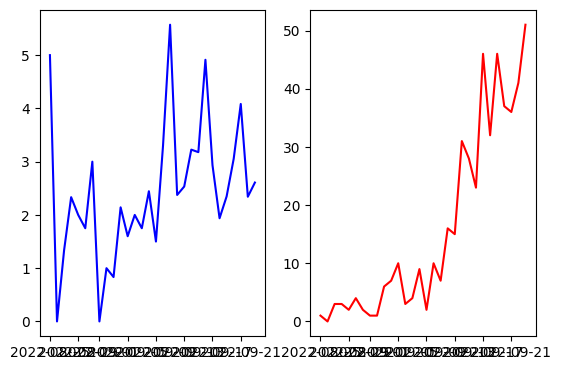

In [40]:
plt.title("Average Violations Per Run")
plt.xlabel("Date (dd/mm)")
plt.ylabel("Violations")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%d/%m"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()
plt.grid(True)

# logs are "accumulative" violations (ie: all violations that exist within the project.
# instead plot as "new" violations per GHA run
# sliding window of average vioaltions per run between (day to day)
def violationsPerRun(data):
    # name => [(date, violations)]
    groups = defaultdict(list)
    for x in data:
        date = dateutil.parser.isoparse(x["date"])
        # time field only became available later but is more accurate
        if "Time" in x:
            date = dateutil.parser.isoparse(x["Time"])

        violations = x["violations"]
        # remove binary biolation as it was very broken at a point
        violations = list(
            filter(lambda x: x["Name"] not in ["BinaryViolation"], violations)
        )
        groupName = x["name"]
        groups[groupName].append(
            (date, len(violations))
        )  # group => (date, len violations)

    # sort each of the data points by date
    for k in groups.keys():
        groups[k] = list(sorted(groups[k], key=lambda x: x[0]))

    # convert to average instead of accumulated
    for k in groups.keys():
        vs = groups[k]
        prev_raw = vs[0][1]
        for i in range(1, len(vs)):
            save = vs[i][1]
            vs[i] = (vs[i][0], vs[i][1] - prev_raw)
            prev_raw = save

        groups[k] = vs

    # find min and max date
    dates = []
    for (k, ds) in groups.items():
        for (d, v) in ds:
            dates.append(d)

    maxDate = max(d for d in dates if isinstance(d, dt.date))
    minDate = min(d for d in dates if isinstance(d, dt.date))

    # round to nearest day start
    minDate = minDate.replace(hour=0, minute=0, second=0, microsecond=0)
    maxDate = maxDate.replace(hour=0, minute=0, second=0, microsecond=0)

    # range of dates monotomically increasing by day value
    dr = date_range(minDate, maxDate)

    xs = []
    ys = []

    total_contribs = []
    for i in range(0, len(dr) - 2):
        lower = dr[i]
        upper = dr[i + 1]

        vs = []
        # find all dates between update and lower range
        for (gn, ds) in groups.items():
            for k, no in ds:
                if lower <= k <= upper:
                    vs.append(no)

        total_contribs.append(len(vs))
        # can't mean empty arrays, hardcode days with no contribs to [0] (zero mean)
        vs = vs if vs != [] else [0]

        ys.append(mean(vs))
        xs.append(lower)

    plt.subplot(1, 2, 1)
    plt.plot(xs, ys, c="blue")
    plt.subplot(1, 2, 2)
    plt.plot(xs, total_contribs, c="red")

violationsPerRun(data)

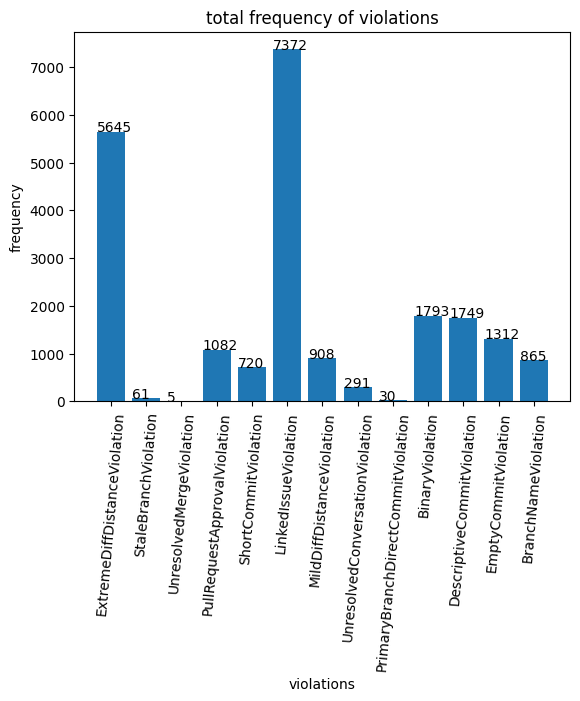

In [4]:
plt.title("total frequency of violations")
plt.xlabel("violations")
plt.ylabel("frequency")
plt.xticks(rotation=85)


def bar(data):
    violations = []
    for x in data:
        for v in x["violations"]:
            violations.append(v["Name"])
    xs = list(set(violations))
    ys = []
    for x in xs:
        ys.append(len(list(filter(lambda ys: ys == x, violations))))

    bars = plt.bar(xs, ys)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x(), yval + 0.005, yval)


bar(data)